In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
from xgboost import XGBClassifier
# import random forest regressor
from sklearn.ensemble import RandomForestRegressor
#import linear regression
from sklearn.linear_model import LinearRegression
# import tqdm
from tqdm import tqdm
import tqdm
#import r2_score
from sklearn.metrics import r2_score
#import confusion matrix
from sklearn.metrics import confusion_matrix
# import roc auc score
from sklearn.metrics import roc_auc_score
from food_crisis_functions import *
import json
with open("forecasting_hyperparameters.json", "r") as file:
    best_params_xgb_regressor= json.load(file)
    
with open("forecasting_hyperparameters_p3.json", "r") as file:
    best_params_xgb_regressor_for_p3= json.load(file)

# read csv
df = pd.read_csv(r'C:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\1.Source Data\forecasting_subset_IPCCH_v1210.csv')
# add dummys for area_id and month year
#df = pd.concat([df, pd.get_dummies(df['area_id'], prefix='area_id')], axis=1)
#df = pd.concat([df, pd.get_dummies(df['date'], prefix='month_year')], axis=1)
# drop lat and lon
#df = df.drop(['lat', 'lon'], axis=1)
###drop fews_ipc_ha
#df = df.drop(['fews_ipc_ha'], axis=1)
# random split train and test

# prepare date from year and month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
# check for inf and replace with na
df = df.replace([np.inf, -np.inf], np.nan)

# replace df['overall_phase], 0 as 1, >5 as 5
df['overall_phase'] = df['overall_phase'].apply(lambda x: 1 if x < 1 else (5 if x > 5 else x))

df_origin = df.copy()
y_pred_test = pd.DataFrame()
model_stats = pd.DataFrame()
#select phase1_percent is not na
df = df_origin[df_origin['phase1_percent'].notna()]

# Sort by region and date
df = df.sort_values(by=['area_id', 'date'])
#drop overall phase
df = df.drop(['overall_phase'], axis=1)
#for each region, set last observation to be test set
# create a series of new outcome, phase2_worse=phase2_percent+phase3_percent+phase4_percent+phase5_percent, phase3_worse=phase3_percent+phase4_percent+phase5_percent, phase4_worse=phase4_percent+phase5_percent, phase5_worse=phase5_percent
df['phase2_worse'] = df['phase2_percent'] + df['phase3_percent'] + df['phase4_percent'] + df['phase5_percent']
df['phase3_worse'] = df['phase3_percent'] + df['phase4_percent'] + df['phase5_percent']
df['phase4_worse'] = df['phase4_percent'] + df['phase5_percent']
df['phase5_worse'] = df['phase5_percent']
#drop phase2_percent, phase3_percent, phase4_percent, phase5_percent, phase1_percent
df = df.drop(['phase2_percent', 'phase3_percent', 'phase4_percent', 'phase5_percent', 'phase1_percent'], axis=1)
# Splitting the data
#test_df = df.groupby('area_id').tail(1)
#train_df = df.drop(test_df.index)
#test_df = test_df.drop(['area_id','date'], axis=1)
#train_df = train_df.drop(['area_id','date'], axis=1)
y_pred_test = pd.DataFrame()
# drop anything after 2022-01-01
#df = df[df['date'] < '2021-01-01']
shape_values_df_ensemble = pd.DataFrame()
df_result = pd.DataFrame()
date = "2024-01-01"  # Define the 'date' variable
#order unique_dates
y_pred_test=pd.DataFrame()



In [2]:
# define date_train as 1 year before date
date_train = (pd.to_datetime(date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
for i in range(2, 6):
    train_df = df[df['date'] < date_train]
    test_df = df[df['date'] >= date]
    train_df = train_df.drop(['date','area_id'], axis=1)
    test_df = test_df.drop(['date','area_id'], axis=1)
    train_df_new = train_df.drop(['phase{}_worse'.format(j) for j in range(2, 6) if j != i], axis=1)
    test_df_new = test_df.drop(['phase{}_worse'.format(j) for j in range(2, 6) if j != i], axis=1)
# drop rows with NaN in phase{}_percent
    train_df_new = train_df_new.dropna(subset=['phase{}_worse'.format(i)])
    test_df_new = test_df_new.dropna(subset=['phase{}_worse'.format(i)])
    test_index = test_df_new.index
    # Split into features and target
    X_train = train_df_new.drop('phase{}_worse'.format(i), axis=1)
    y_train = train_df_new['phase{}_worse'.format(i)]
    X_test = test_df_new.drop('phase{}_worse'.format(i), axis=1)
    y_test = test_df_new['phase{}_worse'.format(i)]
    #fews_ipc_ha_test = X_test['fews_ipc_ha']
    #X_train = X_train.drop(['fews_ipc_ha'], axis=1)
    #X_test = X_test.drop(['fews_ipc_ha'], axis=1)
    if i == 3:
        best_params_xgb_regressor = best_params_xgb_regressor_for_p3
    model = xgb.XGBRegressor(**best_params_xgb_regressor)
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_test)
    # for y_pred_test, add a column to indicate the phase
    #y_pred_test = pd.concat([y_pred_test, pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'phase': [i]*len(y_pred),'fews_ipc_ha':fews_ipc_ha_test,'test_index':test_index})], ignore_index=True)
    y_pred_test = pd.concat([y_pred_test, pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'phase': [i]*len(y_pred),'test_index':test_index})], ignore_index=True)
   
    # shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    #save shap values
    shap_values_df = pd.DataFrame(shap_values, columns=X_train.columns)
    
    # add a column to indicate the phase
    shap_values_df['phase'] = i
    
    # append to shape_values_df_ensemble
    shape_values_df_ensemble = pd.concat([shape_values_df_ensemble, shap_values_df], ignore_index=True)
y_pred_test = convert_prob_to_phase(y_pred_test)
y_test = y_pred_test['overall_phase']
y_pred = y_pred_test['overall_phase_pred']

# confusion matrix
cm = confusion_matrix(y_test, y_pred)


accuracy_score_new, sensitivity, precision, overall_r2 = all_metrics(y_test, y_pred, cm, y_pred_test)

print("Accuracy:", accuracy_score_new)
print("Sensitivity:", sensitivity)
print("Precision:", precision)
print("Overall R²(Phase 3 or more):", overall_r2)

Accuracy: 0.6416763678696158
Sensitivity: 0.7973640856672158
Precision: 0.7152709359605911
Overall R²(Phase 3 or more): 0.411949805132239


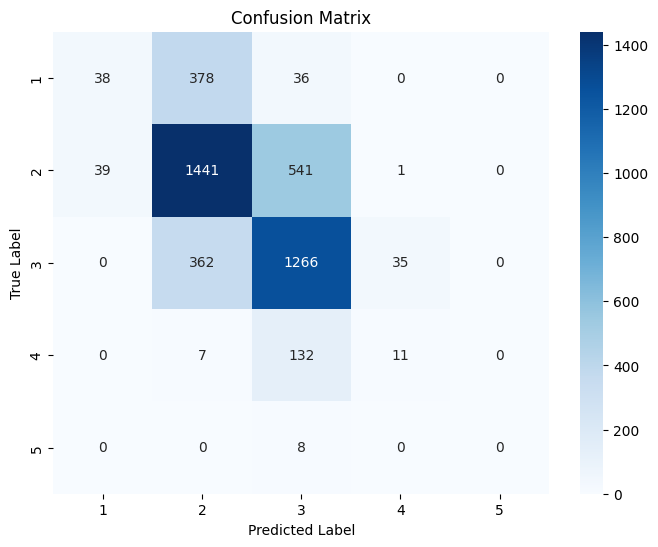

In [3]:
# see confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()